<a href="https://colab.research.google.com/github/meliy-meyada/Tensorflow-Deep-Learning-and-Artificial-Intelligence/blob/main/TF2_0_Stock_Returns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Tensorflow
!pip install -q tensorflow
import tensorflow as tf
print(tf.__version__)

2.8.2


In [2]:
# Additional imports

from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [4]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [5]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [6]:
series = df['close'].values.reshape(-1, 1)

In [7]:
# Normalize the data
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [8]:
# Build the dataset

T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T X D
Y = np.array(Y)
N = len(X)
print("X.shape ", X.shape, "Y.shape ", Y.shape)

X.shape  (1249, 10, 1) Y.shape  (1249,)


In [9]:
# Autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.1),
)

# Train RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),

)

Epoch 1/80


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 3s 31ms/step - loss: 0.0941 - val_loss: 0.0669
Epoch 2/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0111 - val_loss: 0.0348
Epoch 3/80
20/20 [==============================] - 0s 9ms/step - loss: 0.0078 - val_loss: 0.0298
Epoch 4/80
20/20 [==============================] - 0s 10ms/step - loss: 0.0062 - val_loss: 0.0239
Epoch 5/80
20/20 [==============================] - 0s 10ms/step - loss: 0.0061 - val_loss: 0.0225
Epoch 6/80
20/20 [==============================] - 0s 9ms/step - loss: 0.0068 - val_loss: 0.0297
Epoch 7/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0071 - val_loss: 0.0238
Epoch 8/80
20/20 [==============================] - 0s 9ms/step - loss: 0.0060 - val_loss: 0.0275
Epoch 9/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0069 - val_loss: 0.0412
Epoch 10/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0069 - val_loss: 0.0442
Epoch 11/80
20/20 [========

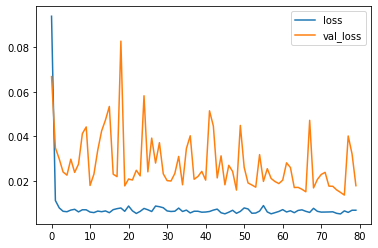

In [10]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1249, 1)


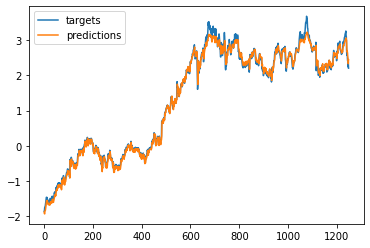

In [11]:
# One-step forecast using true target
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

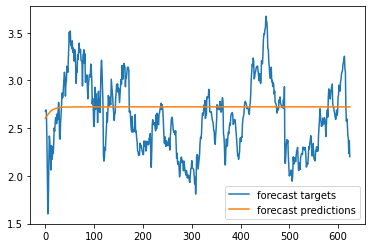

In [12]:
# Multi-step forecast

validation_target = Y[-N//2:]
validation_predictions = []

# Last train input
last_x = X[-N//2] # 1-D array of lenght T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # Update the predictions list
  validation_predictions.append(p)

  # Make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast targets')
plt.plot(validation_predictions, label='forecast predictions')
plt.legend()

In [13]:
# Calculate returns by first shifting thr data
df['PrevClose'] = df['close'].shift(1) # Move everything up 1

# close / prev close
# X[2] X[1]
# X[3] X[2]
# X[4] X[3]
# ...
# X[t] X[t-1]

In [14]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [15]:
# Then the returns is
# (X[t] - X[t-1]) / X[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [16]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


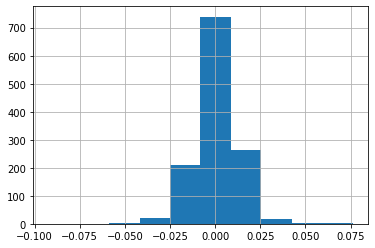

In [17]:
df['Return'].hist()

In [18]:
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [19]:
# Build the dataset

T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T X D
Y = np.array(Y)
N = len(X)
print("X.shape ", X.shape, "Y.shape ", Y.shape)

X.shape  (1248, 10, 1) Y.shape  (1248,)


In [20]:
# Autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.01),
)

# Train RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),

)

Epoch 1/80


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 3s 30ms/step - loss: 0.9977 - val_loss: 1.1477
Epoch 2/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9862 - val_loss: 1.1449
Epoch 3/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9825 - val_loss: 1.1642
Epoch 4/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9847 - val_loss: 1.1480
Epoch 5/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9798 - val_loss: 1.1519
Epoch 6/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9806 - val_loss: 1.1553
Epoch 7/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9777 - val_loss: 1.1430
Epoch 8/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9843 - val_loss: 1.1596
Epoch 9/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9782 - val_loss: 1.1418
Epoch 10/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9780 - val_loss: 1.1516
Epoch 11/80
20/20 [==========

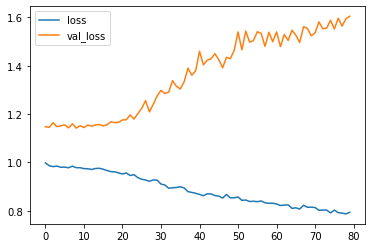

In [21]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1248, 1)


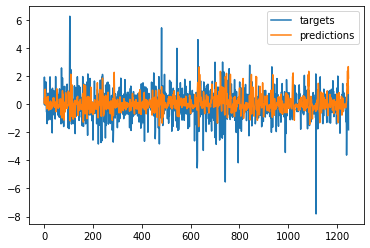

In [22]:
# One-step forecast using true target
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

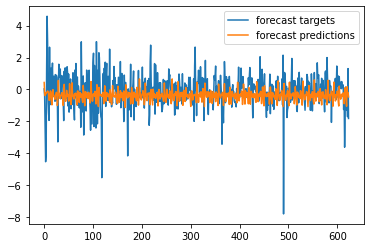

In [23]:
# Multi-step forecast

validation_target = Y[-N//2:]
validation_predictions = []

# Last train input
last_x = X[-N//2] # 1-D array of lenght T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # Update the predictions list
  validation_predictions.append(p)

  # Make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast targets')
plt.plot(validation_predictions, label='forecast predictions')
plt.legend()